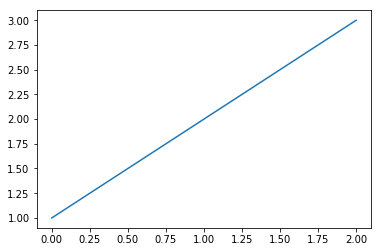

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot([1, 2, 3])

In [2]:
from bs4 import BeautifulSoup

In [3]:
from urllib.request import urlopen

In [4]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from itertools import combinations
from scipy.stats import kendalltau

## Scrap scores from result pages

In [5]:
links = {
    'US': 'http://www.isuresults.com/results/season1718/gpusa2017/CAT001RS.HTM',
    'CA': 'http://www.isuresults.com/results/season1718/gpcan2017/CAT001RS.HTM',
    'FR': 'http://www.isuresults.com/results/season1718/gpfra2017/CAT001RS.HTM',
    'RU': 'http://www.isuresults.com/results/season1718/gprus2017/CAT001RS.HTM',
    'CN': 'http://www.isuresults.com/results/season1718/gpchn2017/CAT001RS.HTM',
    'JP': 'http://www.isuresults.com/results/season1718/gpjpn2017/data0190.htm',
    'EU': 'http://www.isuresults.com/results/season1718/ec2018/CAT001RS.HTM',
    '4C': 'http://www.isuresults.com/results/season1718/fc2018/CAT001RS.HTM',
    'WR': 'http://www.isuresults.com/results/season1718/wc2018/CAT001RS.HTM'
}

In [6]:
def parse_score(link, event_name, year):
    html = urlopen(link)
    bs = BeautifulSoup(html.read(), 'html.parser')

    table_str = str(bs.findAll('table')[0])
    table = pd.read_html(table_str)[0]
    if year == 2017 and event_name == 'JP':
        table = table[[1, 5]].dropna().iloc[1:-1]
    else:
        table = table[[1, 6, 8]].dropna().iloc[2:, :2]
    table.columns = ['name', 'score']
    table['event'] = event_name
    table['score'] = table['score'].astype(float)
    table['year'] = year
    return table

In [7]:
# scores = pd.concat((parse_score(link, event_name, 2017) for event_name, link in links.items()), axis=0)
# scores['name'] = scores['name'].str.replace('\xa0', ' ')
# scores.reset_index(drop=True, inplace=True)
scores = pd.read_csv('scores/2017.csv', names=['name', 'score', 'event', 'year'])

In [8]:
season_scores = scores.loc[scores['event'] != 'WR'].copy()
world_scores = scores.loc[scores['event'] == 'WR', ['name', 'score']].set_index('name').squeeze()

## Implement kendall tau metrics

In [9]:
def return_ranking(skater_scores, world_scores):
    skater_scores = skater_scores.sort_values(ascending=False)
    world_scores = world_scores.sort_values(ascending=False)
    skater_ranking = list(skater_scores.index.intersection(world_scores.index))
    world_ranking = list(world_scores.index.intersection(skater_scores.index))
    return skater_ranking, world_ranking

In [10]:
def calculate_kendall_tau(skater_ranking, world_ranking, verbose=True):
    skater_pairs = set(combinations(skater_ranking, 2))
    world_pairs = set(combinations(world_ranking, 2))
    n_pairs = len(skater_pairs)
    n_concordant_pairs = len(set(skater_pairs) & set(world_pairs))
    print(f'There are {n_concordant_pairs} concordant_pairs out of {n_pairs} pairs')
    tau = (2 * n_concordant_pairs - n_pairs) / n_pairs
    return tau 

## Skater mean model

In [11]:
season_avg = season_scores.groupby('name')['score'].mean().sort_values(ascending=False)
season_avg.head()

name
Shoma UNO           290.786667
Yuzuru HANYU        290.770000
Nathan CHEN         284.835000
Javier FERNANDEZ    277.440000
Boyang JIN          270.486667
Name: score, dtype: float64

In [12]:
skater_ranking_avg, world_ranking = return_ranking(season_avg, world_scores)
calculate_kendall_tau(skater_ranking_avg, world_ranking)

There are 213 concordant_pairs out of 276 pairs


0.5434782608695652

Result agrees with kendalltau from scipy

In [13]:
season_numeric_rank = list(range(len(skater_ranking_avg)))
world_numeric_rank = [skater_ranking_avg.index(skater) for skater in world_ranking]
kendalltau(season_numeric_rank, world_numeric_rank)

KendalltauResult(correlation=0.5434782608695652, pvalue=0.00019870245032364205)

RMSE with mean model

In [14]:
score_comparison = pd.merge(season_scores, season_avg.to_frame(), left_on='name', right_index=True, suffixes=['', '_avg'])
score_comparison['sq_error'] = (score_comparison['score'] - score_comparison['score_avg'])**2
np.sqrt(score_comparison['sq_error'].mean())

10.099364225465914

## Normalized mean model

In [15]:
season_scores['score_normed'] = season_scores.groupby('event')['score'].transform(lambda score: (score - score.mean()) / score.std())

In [16]:
season_normed_avg = season_scores.groupby('name')['score_normed'].mean().sort_values(ascending=False)
season_normed_avg.head()

name
Shoma UNO           1.813727
Nathan CHEN         1.587136
Javier FERNANDEZ    1.574291
Yuzuru HANYU        1.487765
Sergei VORONOV      1.300975
Name: score_normed, dtype: float64

In [17]:
skater_ranking_normed_avg, world_ranking = return_ranking(season_normed_avg, world_scores)
calculate_kendall_tau(skater_ranking_normed_avg, world_ranking)

There are 202 concordant_pairs out of 276 pairs


0.463768115942029

## Linear model

In [18]:
dummies = pd.get_dummies(season_scores[['name', 'event']], prefix=['', ''], prefix_sep='', drop_first=True)
X = dummies.values
X = np.insert(X, 0, 1, axis=1)
y = season_scores['score'].values
coefs_linear = np.linalg.inv(X.T @ X) @ (X.T @ y)
coefs_linear[:10]

array([175.58      , 109.3451848 ,  40.29804314,  19.81723204,
        78.8139453 ,  83.23826378,  45.36853317,   2.23      ,
       105.80944136,  40.05316105])

Double check with sklearn's LinearRegression

In [19]:
lin = LinearRegression(fit_intercept=False)
lin.fit(X, y)
lin.coef_[:10], lin.intercept_

(array([175.58      , 109.3451848 ,  40.29804314,  19.81723204,
         78.8139453 ,  83.23826378,  45.36853317,   2.23      ,
        105.80944136,  40.05316105]), 0.0)

Add removed baseline skater back to skater scores

In [20]:
removed_skater = list(set(season_scores['name']) - set(dummies.columns[:-7]))[0]
removed_skater

'Abzal RAKIMGALIEV'

In [21]:
linear_scores = pd.Series(coefs_linear[1:-7], index=dummies.columns[:-7])
linear_scores[removed_skater] = 0

In [221]:
linear_scores.sort_values(ascending=False)

Nathan CHEN              125.324813
Yuzuru HANYU             123.998533
Shoma UNO                121.774327
Javier FERNANDEZ         111.794249
Sergei VORONOV           109.430185
Adam RIPPON              109.345185
Boyang JIN               105.809441
Mikhail KOLYADA          103.754873
Jason BROWN               92.468533
Misha GE                  84.881731
Alexei BYCHENKO           83.238264
Keiji TANAKA              82.848616
Dmitri ALIEV              82.582222
Max AARON                 81.641297
Patrick CHAN              79.876322
Alexander SAMARIN         78.813945
Kazuki TOMONO             74.429278
Vincent ZHOU              73.516946
Han YAN                   72.279441
Deniss VASILJEVS          72.158888
Moris KVITELASHVILI       67.908016
Ross MINER                67.371092
Keegan MESSING            65.112800
Michal BREZINA            64.754818
Nicolas NADEAU            63.606322
Nam NGUYEN                63.542604
Elladj BALDE              62.620000
Jorik HENDRICKX           62

In [22]:
linear_ranking, world_ranking = return_ranking(linear_scores, world_scores)

In [23]:
calculate_kendall_tau(linear_ranking, world_ranking)

There are 220 concordant_pairs out of 276 pairs


0.5942028985507246

## Log-linear Model

In [24]:
coefs_log_linear = np.linalg.inv(X.T @ X) @ (X.T @ np.log(y))
coefs_log_linear[:10]

array([5.16809478, 0.49459088, 0.19838603, 0.0984977 , 0.37400975,
       0.39169951, 0.22751535, 0.01262078, 0.47378959, 0.20474553])

In [25]:
log_linear_scores = pd.Series(np.exp(coefs_log_linear[1:-7]), index=dummies.columns[:-7])
log_linear_scores[removed_skater] = 0

In [222]:
np.exp(coefs_log_linear[-7:])

array([0.9548574 , 0.96008036, 0.95471129, 0.95990873, 0.92577244,
       0.96236287, 0.90959889])

In [26]:
log_linear_scores.sort_values(ascending=False)

Nathan CHEN              1.733042
Yuzuru HANYU             1.720821
Shoma UNO                1.703357
Javier FERNANDEZ         1.645501
Sergei VORONOV           1.639868
Adam RIPPON              1.639827
Boyang JIN               1.606069
Mikhail KOLYADA          1.601338
Jason BROWN              1.534569
Misha GE                 1.486425
Alexei BYCHENKO          1.479493
Keiji TANAKA             1.474397
Dmitri ALIEV             1.471624
Max AARON                1.466575
Patrick CHAN             1.465519
Alexander SAMARIN        1.453551
Kazuki TOMONO            1.426848
Vincent ZHOU             1.416828
Deniss VASILJEVS         1.413764
Han YAN                  1.410000
Moris KVITELASHVILI      1.384449
Ross MINER               1.375140
Keegan MESSING           1.372633
Michal BREZINA           1.370840
Nicolas NADEAU           1.368474
Nam NGUYEN               1.360689
Jorik HENDRICKX          1.357298
Elladj BALDE             1.356647
Kevin REYNOLDS           1.331618
Liam FIRUS    

In [27]:
log_linear_ranking, world_ranking = return_ranking(log_linear_scores, world_scores)

In [28]:
calculate_kendall_tau(linear_ranking, world_ranking)

There are 220 concordant_pairs out of 276 pairs


0.5942028985507246

## Hybrid Model

In [118]:
season_table = pd.pivot_table(season_scores[['name', 'event', 'score']], values='score', index='name', columns='event')
season_skaters = list(season_table.index)
season_events = list(season_table.columns)

In [216]:
true_scores = season_table.values
skater_scores = np.full(len(season_skaters), 0.5)
event_scores = np.full(len(season_events), 0.5)
bias = 0

alpha = 0.0001
rmses = []

for _ in range(10000):
    diff = np.outer(skater_scores, event_scores) - true_scores
    event_gradients = np.nansum(diff * event_scores, axis=0)
    skater_gradients = np.nansum(diff.T * skater_scores, axis=0)
#     bias_gradient = np.nansum(diff)
    
    event_scores = event_scores - alpha * event_gradients
    skater_scores = skater_scores - alpha * skater_gradients
#     bias = bias - alpha * bias_gradient
    rmse = np.nansum(diff**2)
    rmses.append(rmse)

In [217]:
rmse

9514.808718121556

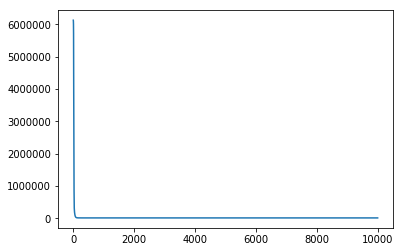

In [218]:
plt.plot(rmses)

In [219]:
skater_scores

array([0.8722474 , 1.43150109, 1.06680149, 0.96151662, 1.26556703,
       1.28937998, 1.09479324, 0.88332561, 1.40542742, 1.06795186,
       0.86803387, 1.09617697, 0.96976543, 0.91412968, 0.94848708,
       1.11138946, 1.23195677, 1.28653393, 0.92356484, 1.18333142,
       0.94330292, 0.89549673, 1.10260589, 1.23120818, 0.89269137,
       1.06788867, 0.85988405, 0.99261713, 1.33564139, 1.43687209,
       1.17988927, 0.98203591, 1.08752096, 1.0524794 , 1.2433505 ,
       1.19377168, 1.28553636, 1.14123269, 1.16397296, 0.74631351,
       1.15450752, 1.13905437, 1.27968112, 1.19232057, 1.39570449,
       1.2965077 , 1.20992511, 1.18719924, 1.51352436, 1.18633479,
       1.27046357, 1.02728701, 1.08086361, 1.03381853, 1.09574992,
       1.20264166, 1.4319616 , 1.48400706, 0.87964943, 1.02070028,
       0.88578699, 0.9624576 , 1.08233999, 0.94356247, 1.23861923,
       1.50057995])

In [220]:
event_scores

array([201.29610051, 193.39397438, 193.46519518, 192.64225227,
       193.15079417, 186.53629836, 193.77174865, 182.61466112])

In [186]:
bias

41.679798429662135

In [170]:
hybrid_scores = pd.Series(skater_scores, index=season_skaters).sort_values(ascending=False)

In [171]:
hybrid_ranking, world_ranking = return_ranking(hybrid_scores, world_scores)

In [172]:
calculate_kendall_tau(hybrid_ranking, world_ranking)

There are 220 concordant_pairs out of 276 pairs


0.5942028985507246